In [26]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [27]:

import numpy as np
import pandas as pd
df=pd.read_csv('merged2_data.csv')
df

,Date,Close,Currently
0,2014-09-17,457.334015,0.09
1,2014-09-18,424.440002,0.09
2,2014-09-19,394.795990,0.09
3,2014-09-20,408.903992,0.09
4,2014-09-21,398.821014,0.09
...,...,...,...
3158,2023-05-11,27000.789063,5.08
3159,2023-05-12,26804.990234,5.08
3160,2023-05-13,26784.078125,5.08
3161,2023-05-14,26930.638672,5.08


In [28]:
hist=df

In [29]:
hist

,Date,Close,Currently
0,2014-09-17,457.334015,0.09
1,2014-09-18,424.440002,0.09
2,2014-09-19,394.795990,0.09
3,2014-09-20,408.903992,0.09
4,2014-09-21,398.821014,0.09
...,...,...,...
3158,2023-05-11,27000.789063,5.08
3159,2023-05-12,26804.990234,5.08
3160,2023-05-13,26784.078125,5.08
3161,2023-05-14,26930.638672,5.08


In [30]:
hist = hist.set_index('Date')


In [31]:
target_col = ['Close', 'Currently']  # Kapanış fiyatı ve faiz oranı  sütunları
target_col 

['Close', 'Currently']

In [32]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [33]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(hist, test_size=0.2)

In [34]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [35]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [36]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [37]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [38]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [39]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 60
epochs = 50
batch_size = 32
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [40]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [41]:
model = build_lstm_model(
    X_train, output_size=2, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
89/89 [==============================] - 1s 5ms/step - loss: 7.6921 - val_loss: 8.7776
Epoch 2/50
89/89 [==============================] - 0s 3ms/step - loss: 7.3729 - val_loss: 8.6092
Epoch 3/50
89/89 [==============================] - 0s 3ms/step - loss: 7.2260 - val_loss: 8.5294
Epoch 4/50
89/89 [==============================] - 0s 3ms/step - loss: 7.1730 - val_loss: 8.5046
Epoch 5/50
89/89 [==============================] - 0s 3ms/step - loss: 7.1721 - val_loss: 8.4729
Epoch 6/50
89/89 [==============================] - 0s 3ms/step - loss: 7.1421 - val_loss: 8.4754
Epoch 7/50
89/89 [==============================] - 0s 3ms/step - loss: 7.1078 - val_loss: 8.4677
Epoch 8/50
89/89 [==============================] - 0s 3ms/step - loss: 7.0760 - val_loss: 8.4629
Epoch 9/50
89/89 [==============================] - 0s 3ms/step - loss: 7.0992 - val_loss: 8.4628
Epoch 10/50
89/89 [==============================] - 0s 3ms/step - loss: 7.0879 - val_loss: 8.4890
Epoch 11/50
89/89 [

In [42]:
print(model.summary()) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60)                15120     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 122       
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 15,242
Trainable params: 15,242
Non-trainable params: 0
_________________________________________________________________
None


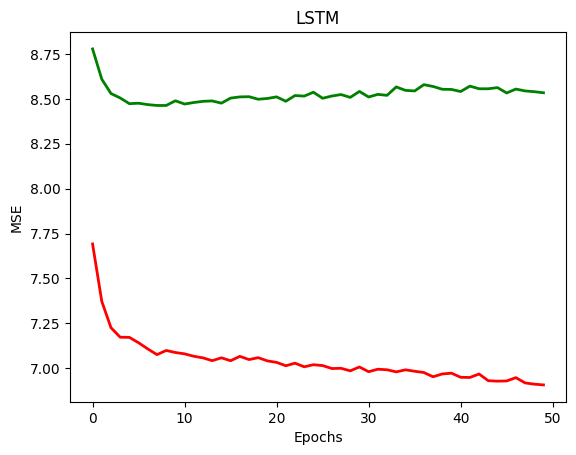

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [44]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

10/10 [==============================] - 0s 984us/step


In [45]:
import numpy as np

# Hata karelerinin hesaplanması
errors = (preds - y_test) ** 2

# Hata karelerinin ortalamasının hesaplanması
MSE = np.mean(errors)
MSE


505.6154496289878

In [46]:
RMSE = np.sqrt(MSE)
RMSE

22.485894459171238

In [47]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Hataların hesaplanması
errors = np.abs(preds - y_test)

# Hataların ortalamasının hesaplanması
MAE = np.mean(errors)
MAE

8.533626428308821

In [48]:
import numpy as np

# Ortalama değerlerin hesaplanması
y_mean = np.mean(y_test)

# Toplam hata karelerinin hesaplanması
ss_total = np.sum((y_test - y_mean)**2)

# İç hata karelerinin hesaplanması
ss_residual = np.sum((y_test - preds)**2)

# R2 değerinin hesaplanması
R2 = 1 - (ss_residual / ss_total)
R2

0.18080451030436395

In [53]:
import pandas as pd

# Değerleri bir sözlük yapısında sakla
results = {'MSE': [MSE], 'RMSE': [RMSE], 'MAE': [MAE], 'R2': [R2]}

# DataFrame oluştur ve index değerlerini varsayılan değerlerle ata
LSTM_ERROR1= pd.DataFrame.from_dict(results, orient='index').T

# DataFrame'i ERROR ismiyle kaydet
LSTM_ERROR1 = LSTM_ERROR1.to_string(index=False)

# ERROR'u yazdır

print(LSTM_ERROR)

       MSE      RMSE      MAE       R2
510.749059 22.599758 8.578092 0.172487


In [54]:
import pandas as pd

# Değerleri bir sözlük yapısında sakla
results = {'MSE': [MSE], 'RMSE': [RMSE], 'MAE': [MAE], 'R2': [R2]}

# DataFrame oluştur ve index değerlerini varsayılan değerlerle ata
LSTM_ERROR1 = pd.DataFrame.from_dict(results, orient='index').T

# Çıktıyı metin dosyasına aktar
output_text = LSTM_ERROR1.to_string(index=False)

# Metin dosyasını kaydet
with open('LSTM_ERROR1.txt', 'w') as file:
    file.write(output_text)
